# Import libraries

In [70]:
import mne 
import pandas as pd
import numpy as np
import os
import glob
from IPython.display import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
# import seaborn as sns
import random
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

seed = 123
random.seed = seed

# Read the data

In [57]:
print('Total amount of files in SMNI_CMI_TRAIN directory: ' + str(len(os.listdir('TRAIN/'))))

Total amount of files in SMNI_CMI_TRAIN directory: 469


In [71]:
_dfs_list = []
for csv_file in glob.glob('TRAIN/*.csv'):
    # read the csv file into a dataframe and append it to the list
    _dfs_list.append(pd.read_csv(csv_file))
# concatenate the list of dataframes into a single dataframe
df = pd.concat(_dfs_list)
# delete the _dfs_list variable to free up memory space after the loop is done  
del(_dfs_list)
# drop the index column from the dataframe
df = df.drop(['Unnamed: 0'], axis=1)

# df.loc[df['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch'  ## remove comma sign from stimulus name
# get the first 5 rows of the dataframe
df.head()

trial number sensor position  sample num  sensor value subject identifier  \
0             0             FP1           0        -8.921                  a   
1             0             FP1           1        -8.433                  a   
2             0             FP1           2        -2.574                  a   
3             0             FP1           3         5.239                  a   
4             0             FP1           4        11.587                  a   

  matching condition  channel         name      time  
0             S1 obj        0  co2a0000364  0.000000  
1             S1 obj        0  co2a0000364  0.003906  
2             S1 obj        0  co2a0000364  0.007812  
3             S1 obj        0  co2a0000364  0.011719  
4             S1 obj        0  co2a0000364  0.015625

trial number: number of the trial (obviously)

sensor postition: position of electrode placed on subject's scalp (based on International 10-20 system)

sample num: 0-255

sensor value: value in microvolts

subject identifier: a - Alcoholic; c - Control

matching condition:

    S1 obj - a single object shown;

    S2 match - object 2 shown in a matching condition (S1 was identical to S2),

    S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)

channel: channel number (0-63). Basically, it's the same as sensor position column, so one of these columns can be dropped

name: a serial code assigned to each subject

time: inverse of sample num measured in seconds.

I have changed some sensor positions so they match the basics for head topography visualization. Also, I have removed those positions which equal to X, Y and ND since I couldnt 
figure out which regions they respond to.

In [72]:
# get the list of channel names in the dataframe
channel_list = list(set(df['sensor position']))
# sort the list of channel names
channel_list.sort()
# create a dictionary of channel names and their corresponding names 
channel_mapping = {
    'AFZ':'AFz', 
    'CPZ':'CPz', 
    'CZ':'Cz', 
    'FCZ':'FCz', 
    'FP1':'Fp1',
    'FP2':'Fp2', 
    'FPZ':'Fpz', 
    'FZ':'Fz', 
    'OZ':'Oz', 
    'POZ':'POz', 
    'PZ':'Pz',
}

channel_mapping_full = dict()
for channel in channel_list:
    if channel in channel_mapping:
        channel_mapping_full[channel] = channel_mapping[channel]
    else:
        channel_mapping_full[channel] = channel
    
channel_list_fixed = [channel_mapping_full[ch] for ch in channel_list]

df['sensor position'] = df['sensor position'].map(channel_mapping_full)
df.head()

trial number sensor position  sample num  sensor value subject identifier  \
0             0             Fp1           0        -8.921                  a   
1             0             Fp1           1        -8.433                  a   
2             0             Fp1           2        -2.574                  a   
3             0             Fp1           3         5.239                  a   
4             0             Fp1           4        11.587                  a   

  matching condition  channel         name      time  
0             S1 obj        0  co2a0000364  0.000000  
1             S1 obj        0  co2a0000364  0.003906  
2             S1 obj        0  co2a0000364  0.007812  
3             S1 obj        0  co2a0000364  0.011719  
4             S1 obj        0  co2a0000364  0.015625

In [73]:
# transpose the table to make the data extraction easier

transposed_df_list = []

for group_df in tqdm(df.groupby(['name', 'trial number', 'matching condition', 'sensor position', 'subject identifier'])):
    _df = pd.DataFrame(group_df[1]['sensor value']).T
    _df.columns = [f'sample_{idx}' for idx in range(256)]
    _df['name'] = group_df[0][0]
    _df['trial number'] = group_df[0][1]
    _df['matching condition'] = group_df[0][2]
    _df['sensor position'] = group_df[0][3]
    _df['subject identifier'] = group_df[0][4]
    
    transposed_df_list.append(_df)
    
df = pd.concat(transposed_df_list)
df = df[[*df.columns[-5:],*df.columns[0:-5]]]
df = df.reset_index(drop=True)
df.head(3)

100%|██████████| 29952/29952 [00:36<00:00, 830.47it/s] 


name  trial number matching condition sensor position  \
0  co2a0000364             0             S1 obj             AF1   
1  co2a0000364             0             S1 obj             AF2   
2  co2a0000364             0             S1 obj             AF7   

  subject identifier  sample_0  sample_1  sample_2  sample_3  sample_4  ...  \
0                  a    -2.146    -2.146    -1.658    -0.682     2.248  ...   
1                  a     1.129     0.641    -0.336    -0.824     0.641  ...   
2                  a   -16.856    -7.090     7.558    19.277    23.183  ...   

   sample_246  sample_247  sample_248  sample_249  sample_250  sample_251  \
0      -1.658       0.295       2.736       4.201       3.713       1.272   
1       4.059      -0.336      -2.777      -0.824       3.571       5.035   
2      17.324       9.511       1.699      -2.207      -2.207       1.211   

   sample_252  sample_253  sample_254  sample_255  
0      -0.682      -0.193       3.225       7.619  
1       4.059       2.106       1.617       4.059  
2       5.117       8.046      10.000      11.464  

[3 rows x 261 columns]

# Data visulization

# Display the data as images mapping

In [74]:
def get_record_df(df, name, trial_number, matching_condition, channel_list):
    df_record = df[df['name'].eq(name) & df['trial number'].eq(trial_number) & df['matching condition'].eq(matching_condition)].set_index(['sensor position']).loc[channel_list]
    return df_record

df_record = get_record_df(df, 'co2a0000364', 0, 'S1 obj', channel_list_fixed)
df_record

name  trial number matching condition  \
sensor position                                                 
AF1              co2a0000364             0             S1 obj   
AF2              co2a0000364             0             S1 obj   
AF7              co2a0000364             0             S1 obj   
AF8              co2a0000364             0             S1 obj   
AFz              co2a0000364             0             S1 obj   
...                      ...           ...                ...   
TP7              co2a0000364             0             S1 obj   
TP8              co2a0000364             0             S1 obj   
X                co2a0000364             0             S1 obj   
Y                co2a0000364             0             S1 obj   
nd               co2a0000364             0             S1 obj   

                subject identifier  sample_0  sample_1  sample_2  sample_3  \
sensor position                                                              
AF1                              a    -2.146    -2.146    -1.658    -0.682   
AF2                              a     1.129     0.641    -0.336    -0.824   
AF7                              a   -16.856    -7.090     7.558    19.277   
AF8                              a   -10.020    -7.090     1.211    10.488   
AFz                              a    -0.987    -1.475    -0.987    -0.010   
...                            ...       ...       ...       ...       ...   
TP7                              a    -9.338   -12.268    -8.850    -1.526   
TP8                              a    -3.082    -4.059    -3.571    -1.129   
X                                a    -5.269    -5.758    -2.828     1.567   
Y                                a    -5.636    -2.706     1.689     5.595   
nd                               a    -8.901    -7.924    -3.042     4.771   

                 sample_4  sample_5  ...  sample_246  sample_247  sample_248  \
sensor position                      ...                                       
AF1                 2.248     5.178  ...      -1.658       0.295       2.736   
AF2                 0.641     3.571  ...       4.059      -0.336      -2.777   
AF7                23.183    18.789  ...      17.324       9.511       1.699   
AF8                13.906    10.976  ...      28.554      27.089      15.859   
AFz                 2.431     4.873  ...       0.478      -0.498      -0.498   
...                   ...       ...  ...         ...         ...         ...   
TP7                 4.822     7.263  ...      19.958      14.587       3.357   
TP8                 2.777     6.195  ...       2.777       2.289       0.824   
X                   5.961     9.379  ...      19.145      18.168      16.215   
Y                   9.013    10.478  ...      24.150      20.243      11.454   
nd                 11.607    14.048  ...      11.119       8.677       5.259   

                 sample_249  sample_250  sample_251  sample_252  sample_253  \
sensor position                                                               
AF1                   4.201       3.713       1.272      -0.682      -0.193   
AF2                  -0.824       3.571       5.035       4.059       2.106   
AF7                  -2.207      -2.207       1.211       5.117       8.046   
AF8                   0.722     -10.020     -10.997      -2.696       9.511   
AFz                   0.478       0.966       0.966       0.966       0.478   
...                     ...         ...         ...         ...         ...   
TP7                  -6.897      -9.827      -3.967       6.775      14.587   
TP8                   0.336       1.312       3.265       4.242       2.777   
X                    13.774      10.844       8.891       8.891      11.820   
Y                     4.618       3.153       6.571      12.431      15.849   
nd                    2.818       2.330       3.306       4.283       4.771   

                 sample_254  sample_255  
sensor position                          
AF1       

In [75]:
def get_signal_array(df, name, trial_number, matching_condition, channel_list):
    df_record = get_record_df(df, name, trial_number, matching_condition, channel_list)
    return df_record.to_numpy()[:, 4:]

signal_array = get_signal_array(df, 'co2a0000364', 10, 'S1 obj', channel_list_fixed)
signal_array.shape

(64, 256)

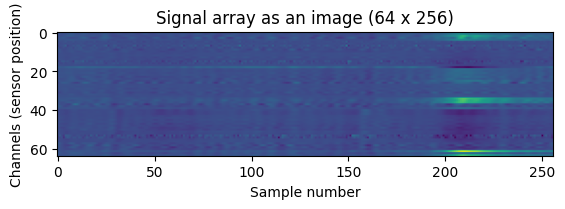

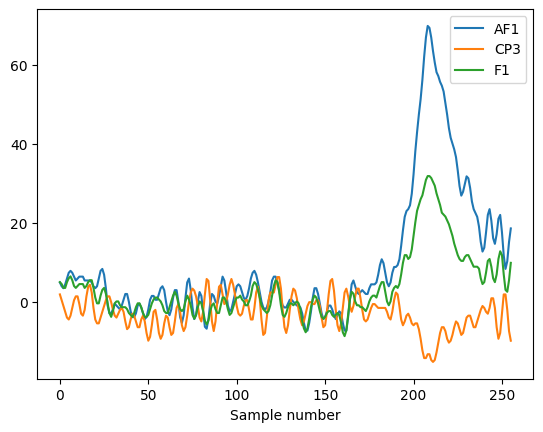

In [76]:
plt.title('Signal array as an image (64 x 256)')
plt.ylabel('Channels (sensor position)');
plt.xlabel('Sample number');
plt.imshow(signal_array.astype(int));
plt.show()

channels_to_display = ['AF1', 'CP3', 'F1']
for channel in channels_to_display:
    plt.xlabel('Sample number');
    plt.plot(signal_array[channel_list.index(channel)]);
plt.legend(channels_to_display);

# Load signal data to an MNE Raw object

Create Info object. input = channel list, data freq, channel types

Create Raw object. input = the signal array and the Info object

Set Raw object montage. After we attach a montage to the signal, we can display it in a topmap.

In [77]:
info = mne.create_info(ch_names=channel_list_fixed, sfreq=256, ch_types=['eeg']*64)
raw = mne.io.RawArray(signal_array, info)

standard_1020_montage = mne.channels.make_standard_montage('standard_1020');
raw.drop_channels(['X', 'Y', 'nd'])
raw.set_montage(standard_1020_montage)

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.


<RawArray | 61 x 256 (1.0 s), ~196 kB, data loaded>

# Plotting the frequency

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


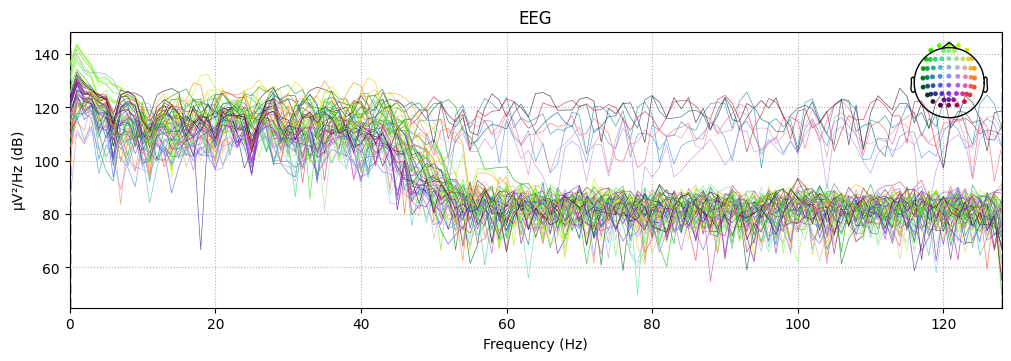

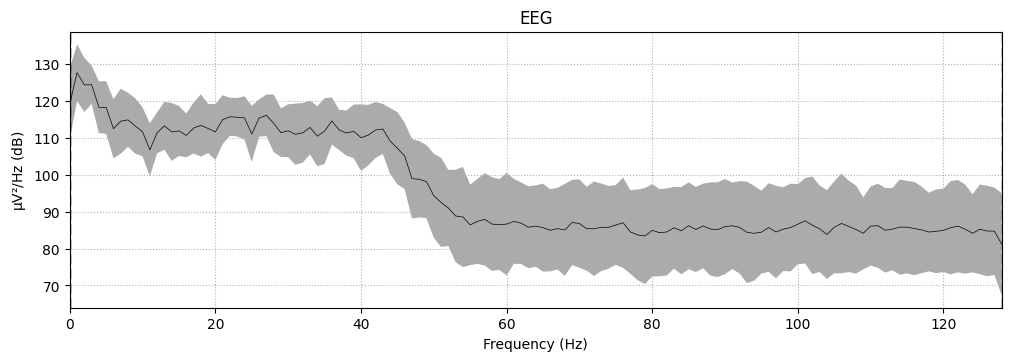

In [78]:
raw.plot_psd();
raw.plot_psd(average=True);

# data cleaning and noise reduction

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\pc\AppData\Local\Temp\ipykernel_3832\2099550416.py:1: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw_filtered = raw.copy().filter(8,30, verbose=False);
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Effective window size : 1.000 (s)


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


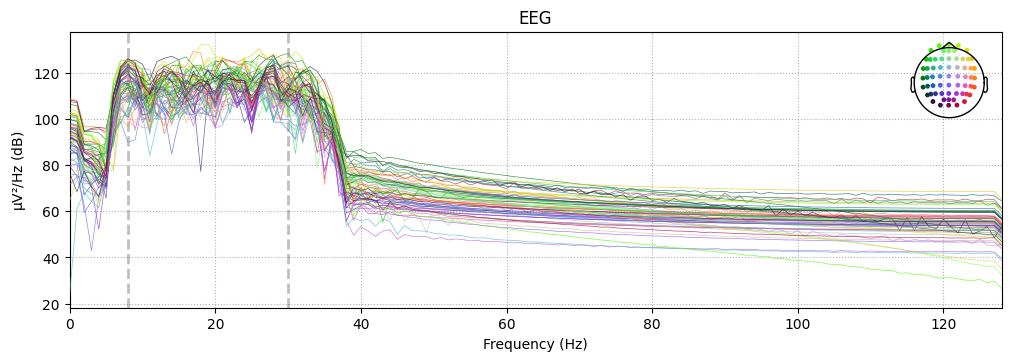

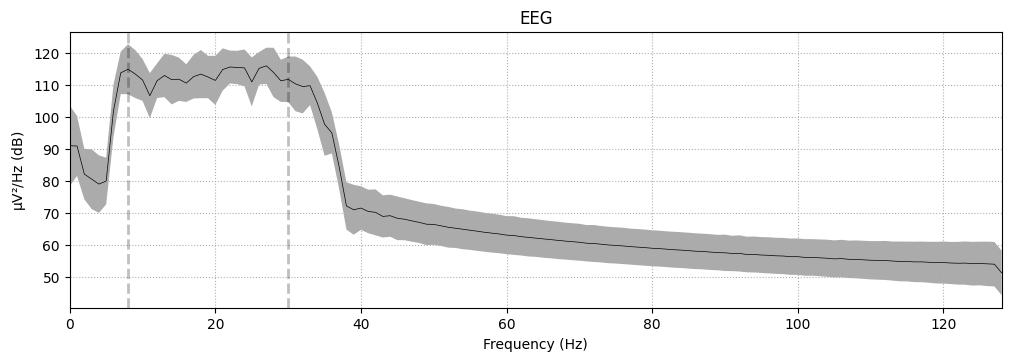

In [79]:
raw_filtered = raw.copy().filter(8,30, verbose=False);
raw_filtered.plot_psd();
raw_filtered.plot_psd(average=True);

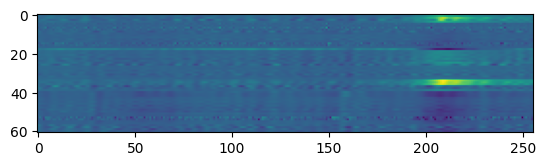

C:\Users\pc\AppData\Local\Temp\ipykernel_3832\3450553692.py:3: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  plt.imshow(raw.copy().filter(1,10, verbose=False).get_data());


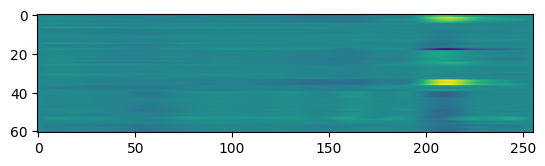

C:\Users\pc\AppData\Local\Temp\ipykernel_3832\3450553692.py:6: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  plt.plot(raw.copy().filter(8,30, verbose=False).get_data()[40])


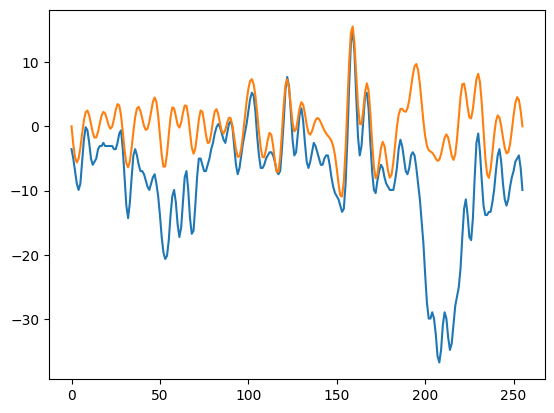

In [80]:
plt.imshow(raw.get_data())
plt.show()
plt.imshow(raw.copy().filter(1,10, verbose=False).get_data());
plt.show()
plt.plot(raw.copy().get_data()[40])
plt.plot(raw.copy().filter(8,30, verbose=False).get_data()[40])

# ICA

C:\Users\pc\AppData\Local\Temp\ipykernel_3832\858203707.py:2: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  ica.fit(raw.copy().filter(1,None, verbose=False), verbose=False)
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


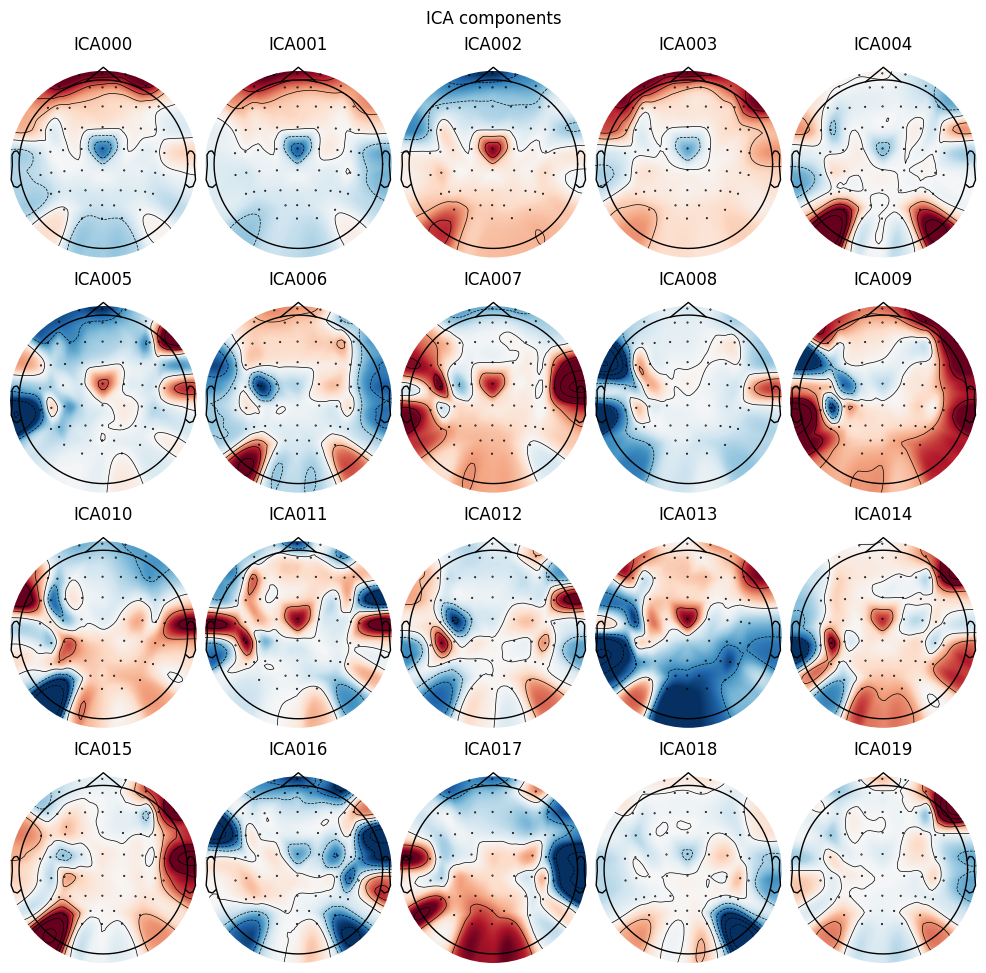

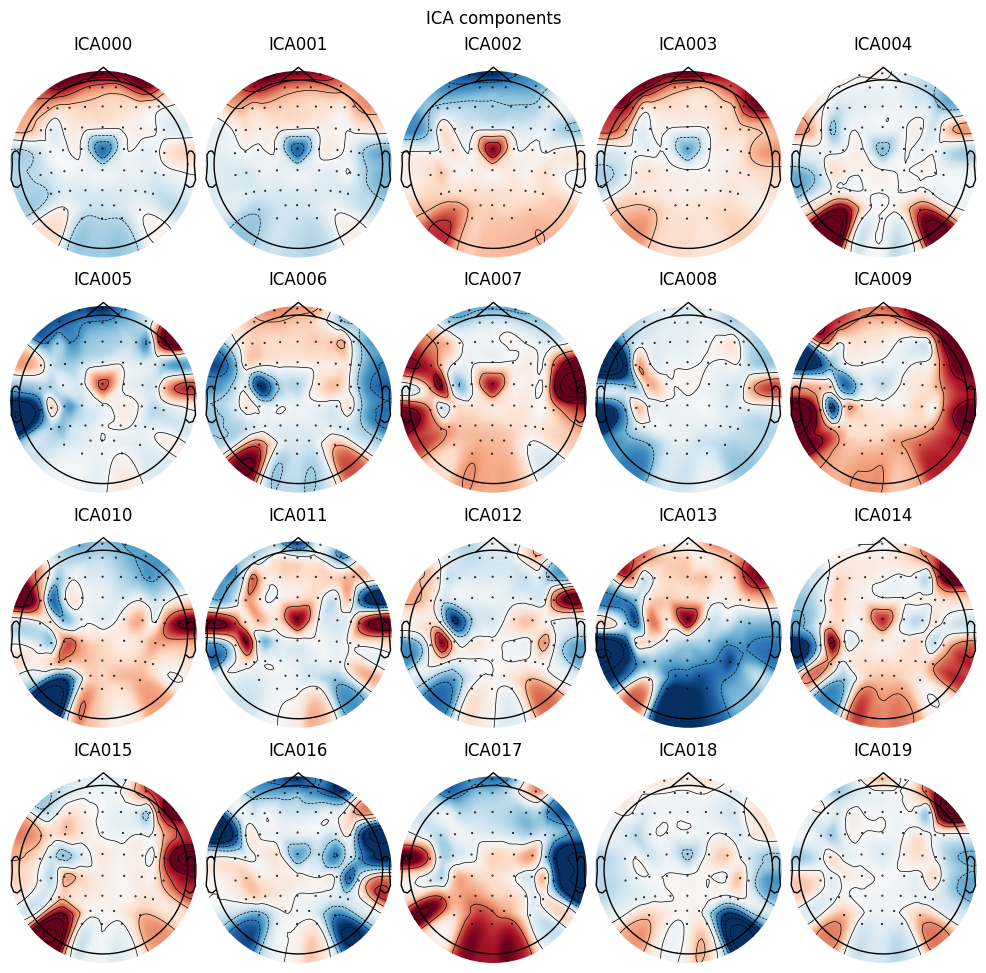

In [81]:
ica = mne.preprocessing.ICA(random_state=42, n_components=20)
ica.fit(raw.copy().filter(1,None, verbose=False), verbose=False)
ica.plot_components()

# topographic map

In [82]:
def plot_eeg_topomap(signal_array, save_path_animation=None, show_names=False, start_time=0.05, end_time=1, step_size=0.1):
    # select channel X,Y format
    montage = mne.channels.make_standard_montage('standard_1020')
    
    # remove channels that don't have X,Y positions
    ch_to_remove = []
    for ch in channel_list_fixed:
        if ch not in list(set(montage.ch_names).intersection(channel_list_fixed)):
            ch_to_remove.append(channel_list_fixed.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)
    
    # create info+evoked objects
    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(channel_list_fixed)), sfreq=256, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)
    
    # set channel X,Y positions
    evoked.set_montage(montage)

    # plot img
    evoked.plot_topomap(np.arange(start_time, end_time, step_size), ch_type='eeg', time_unit='s', ncols=5, nrows=2, show_names=show_names);

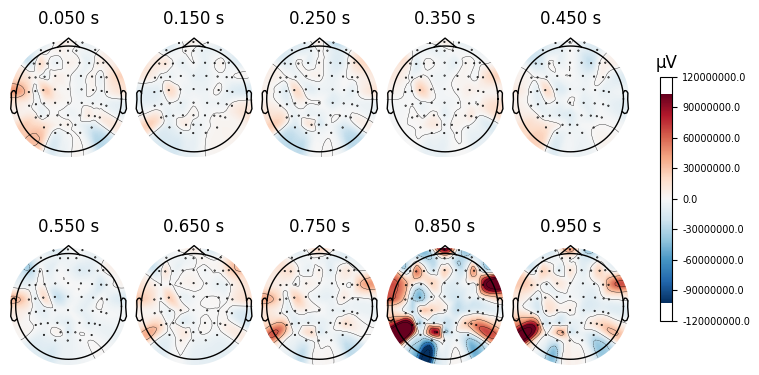

In [83]:
plot_eeg_topomap(signal_array, show_names=False)

# animation

In [84]:
def plot_eeg_topomap_animation(signal_array, save_path_animation, start_time=0.00, end_time=1, step_size=0.01, frame_rate=10):
    # select channel X,Y format
    montage = mne.channels.make_standard_montage('standard_1020')
    
    # remove channels that don't have X,Y positions
    ch_to_remove = []
    for ch in channel_list_fixed:
        if ch not in list(set(montage.ch_names).intersection(channel_list_fixed)):
            ch_to_remove.append(channel_list_fixed.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)
    
    # create info+evoked objects
    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(channel_list_fixed)), sfreq=256, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)
    
    # set channel X,Y positions
    evoked.set_montage(montage)
    
    # (optional) plot and save animation
    if save_path_animation:
        fig, anim = evoked.animate_topomap(times=np.arange(start_time, end_time, step_size), frame_rate=frame_rate, butterfly=True, blit=False, );
        anim.save(save_path_animation);
        print('saved to', save_path_animation)

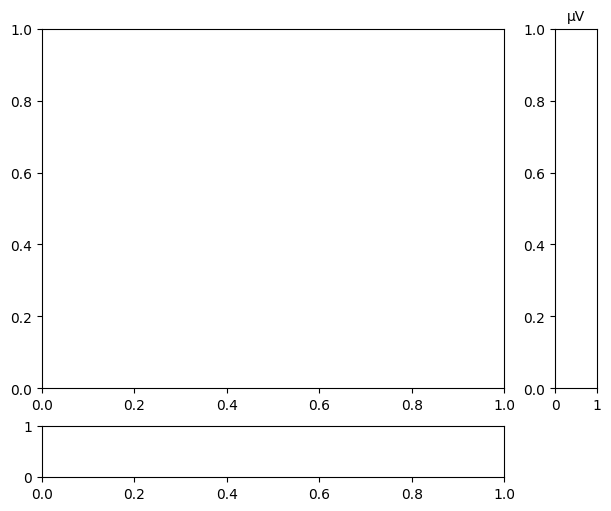

MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to ./gif.gif


In [85]:
plot_eeg_topomap_animation(signal_array, './gif.gif')

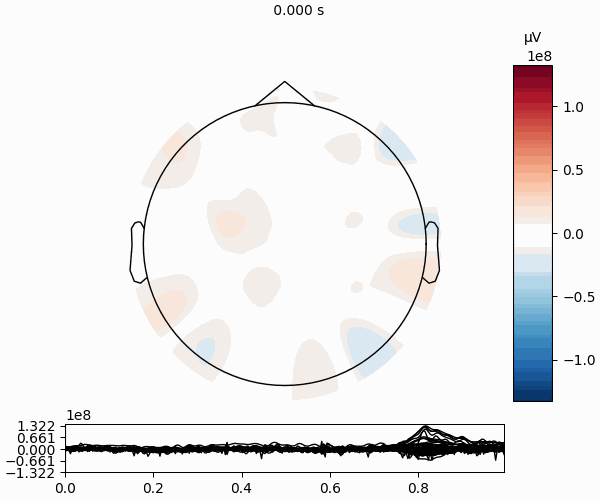

In [86]:
Image(filename='gif.gif')

No projector specified for this dataset. Please consider the method self.add_proj.


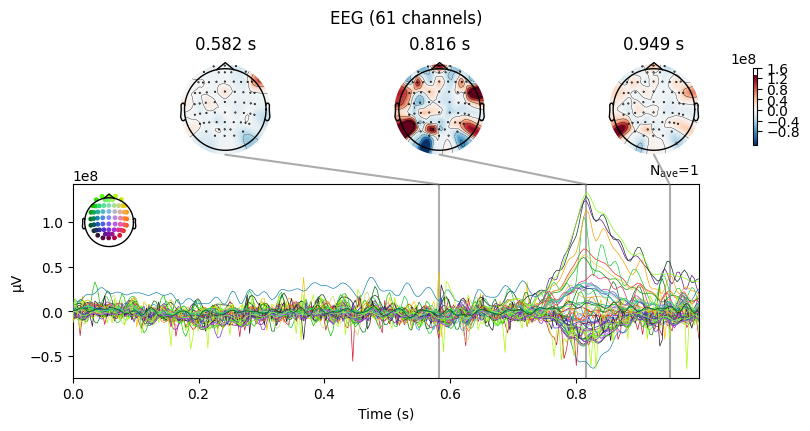

In [87]:
def plot_eeg_joint_topomap(signal_array, save_path_animation=None, show_names=False, start_time=0.05, end_time=1, step_size=0.1):
    # select channel X,Y format
    montage = mne.channels.make_standard_montage('standard_1020')
    
    # remove channels that don't have X,Y positions
    ch_to_remove = []
    for ch in channel_list_fixed:
        if ch not in list(set(montage.ch_names).intersection(channel_list_fixed)):
            ch_to_remove.append(channel_list_fixed.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)
    
    # create info+evoked objects
    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(channel_list_fixed)), sfreq=256, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)
    
    # set channel X,Y positions
    evoked.set_montage(montage)

    # plot img
    evoked.plot_joint();
    
plot_eeg_joint_topomap(signal_array)